In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
import wandb

import torch
from torch import nn
from torchvision import models
import torch.optim as optim

from dataset import get_dataloaders, get_tiles_datasets
from utils import seed_everything
from trainer import Trainer

# Params
Image.MAX_IMAGE_PIXELS = 1e11
CFG = {
    'seed': 42,
    'base_model': 'resnet50',   # resnet18/34/50, efficientnet_b0/b1/b2/b3/b4
    'img_size': 512,
    'batch_size': 32,
    'freeze_epochs': 1,
    'epochs': 5,
    'base_lr': 1e-4,
    'affine_degrees': 0,
    'affine_translate': None,
    'affine_scale': None,
    'dataloader_num_workers': 8,
    'scheduler_step_size': 2,
    'img_color_mean': [0.8708488980328596, 0.75677901508938, 0.8545134911215124],
    'img_color_std': [0.08086288591996027, 0.11553960008706814, 0.06914169213328555],
    'tile_num': 32,
    'optimizer': 'AdamW',
    'scheduler': 'StepLR',
    'lr_gamma': 0.1,
    'sgd_momentum': 0.9,
    'valid_type': 'all_tmas',
    'tile_set': 'train_tiles_1024_p50_drop60_v6',
    'tile_table_postfix': '',
    'color_jitter': {'brightness': 0, 'contrast': 0, 'saturation': 0, 'hue': 0}
}
tags=['torch', 'tiles', 'baseline']
notes = ''
plot_samples = False

# Wandb
wandb.login(key='1b0401db7513303bdea77fb070097f9d2850cf3b')
run = wandb.init(project='kaggle-ubc-ocean', config=CFG, tags=tags, notes=notes)

# Label encoder/decoder
encode = {'HGSC': 0, 'LGSC': 1, 'EC': 2, 'CC': 3, 'MC': 4}
decode = {v: k for k, v in encode.items()}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_image_dir = os.path.join(results_dir, CFG['tile_set'])
train_csv = '{}_sample{}.csv'.format(CFG['tile_set']+CFG['tile_table_postfix'], CFG['tile_num'])

# Seed
seed_everything(CFG['seed'])

# Load data
df = pd.read_csv(os.path.join(results_dir, train_csv))
df['label'] = df.loc[:,'label'].map(encode)

# Functions
def train_model(CFG, train_image_dir, df_train, df_validation, encode, validate=True, wandb_log=False):
    # Data loaders
    datasets = get_tiles_datasets(CFG, train_image_dir, df_train, df_validation)
    dataloaders = get_dataloaders(CFG, datasets)

    # Model definition
    model = models.get_model(CFG['base_model'], weights='DEFAULT').to(device)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last fully-connected layer
    if CFG['base_model'].startswith('resnet'):
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(encode)).to(device)
    elif CFG['base_model'].startswith('efficientnet'):
        model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=len(encode), bias=True).to(device)
    elif CFG['base_model'].startswith('convnext'):
        model.classifier[2] = nn.Linear(in_features=model.classifier[2].in_features, out_features=len(encode), bias=True).to(device)
    elif CFG['base_model'].startswith('vit'):
        model.heads.head = nn.Linear(in_features=model.heads.head.in_features, out_features=len(encode), bias=True).to(device)
    elif CFG['base_model'].startswith('swin'):
        model.head = nn.Linear(in_features=model.head.in_features, out_features=len(encode), bias=True).to(device)
    
    # Loss function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    if CFG['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=CFG['base_lr'], momentum=CFG['sgd_momentum'])
    elif CFG['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=CFG['base_lr'])
    elif CFG['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=CFG['base_lr'])
    
    # Scheduler
    if CFG['scheduler'] == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CFG['scheduler_step_size'], gamma=CFG['lr_gamma'], verbose=True)
    elif CFG['scheduler'] == 'CyclicLR':
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=CFG['base_lr'], max_lr=CFG['base_lr']*5,
                                                step_size_up=5, cycle_momentum=False, mode='triangular2', verbose=True)
    elif CFG['scheduler'] == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs']+CFG['freeze_epochs'], verbose=True)
    elif CFG['scheduler'] == 'OneCycleLR':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG['base_lr'], total_steps=CFG['epochs']+CFG['freeze_epochs'], verbose=True)

    # Training
    trainer = Trainer(model, dataloaders, loss_fn, optimizer, scheduler, device, metric='balanced_accuracy', wandb_log=wandb_log)
    model, _ = trainer.train_epochs(num_epochs=CFG['freeze_epochs'], validate=validate)
    trainer.unfreeze()
    model, balanced_acc = trainer.train_epochs(num_epochs=CFG['epochs'], validate=validate)
    return model, balanced_acc

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: naraiadam88. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/latlab/.netrc


In [2]:
# Split train/valid
skf = StratifiedGroupKFold(n_splits=5, random_state=CFG['seed'], shuffle=True)
if 'valid_type' in CFG and CFG['valid_type'] == 'all_tmas':
    df_tma = df[df['is_tma']==True].copy().reset_index(drop=True)
    df_wsi = df[df['is_tma']==False].copy().reset_index(drop=True)
    train_index, valid_index = next(skf.split(X=np.zeros(len(df_wsi['label'])), y=df_wsi['label'], groups=df_wsi['orig_image_id']))
    df_train = df_wsi.iloc[train_index]
    df_validation = df_wsi.iloc[valid_index]
    df_validation = pd.concat([df_validation, df_tma], ignore_index=True).sample(frac=1).reset_index(drop=True)
else:
    train_index, valid_index = next(skf.split(X=np.zeros(len(df['label'])), y=df['label'], groups=df['orig_image_id']))
    df_train = df.iloc[train_index]
    df_validation = df.iloc[valid_index]

In [3]:
# Show training data
if plot_samples:
    dataloaders = get_dataloaders(CFG, get_tiles_datasets(CFG, train_image_dir, df_train, df_validation))
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloaders['train']):
            plt.figure(figsize=(np.ceil(len(X)/2), 12))
            for i in range(len(X)):
                plt.subplot(int(np.ceil(len(X)/6)), 6, i+1)
                img_data = X[i].permute(1, 2, 0).cpu().numpy()
                # Normalize images for plotting (since there are negative values in tensors)
                img_data_norm = np.clip(((img_data - img_data.mean(axis=(0, 1, 2))) / img_data.std(axis=(0, 1, 2)))/4 + 0.5, 0, 1)
                plt.imshow(img_data_norm)
                plt.title(f'{decode[y[i].item()]}')
            if batch >= 1:
                break

In [4]:
# Model training
model, balanced_acc = train_model(CFG, train_image_dir, df_train, df_validation, encode, wandb_log=True)
torch.save(model.state_dict(), os.path.join(results_dir, 'models', f'ubc-ocean-{run.name}.pt'))
wandb.finish()

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 1/1
----------


100%|██████████| 104/104 [00:34<00:00,  3.03it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 1.3406, test loss: 1.2512, balanced_accuracy: 0.3045

Training complete in 2m 59s
Final balanced_accuracy: 0.304489

Epoch 1/5
----------


100%|██████████| 104/104 [00:12<00:00,  8.38it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.7767, test loss: 0.9068, balanced_accuracy: 0.6181

Epoch 2/5
----------


100%|██████████| 104/104 [00:12<00:00,  8.40it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
train loss: 0.5057, test loss: 0.8180, balanced_accuracy: 0.6363

Epoch 3/5
----------


100%|██████████| 104/104 [00:12<00:00,  8.38it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.4474, test loss: 0.8340, balanced_accuracy: 0.6424

Epoch 4/5
----------


100%|██████████| 104/104 [00:12<00:00,  8.38it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
train loss: 0.4141, test loss: 0.8167, balanced_accuracy: 0.6504

Epoch 5/5
----------


100%|██████████| 104/104 [00:12<00:00,  8.40it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
train loss: 0.4064, test loss: 0.8361, balanced_accuracy: 0.6396

Training complete in 12m 21s
Final balanced_accuracy: 0.639580



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


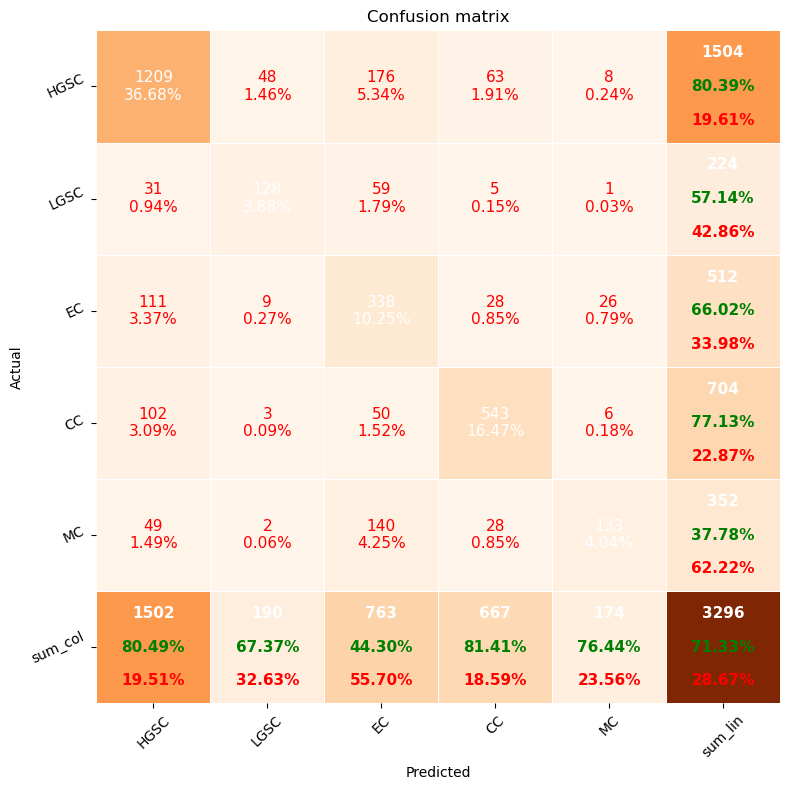

In [17]:
# Confusion matrix
import warnings
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
loss_fn = nn.CrossEntropyLoss(reduction='none')
datasets = get_tiles_datasets(CFG, train_image_dir, df_train, df_validation[df_validation.is_tma==False])
dataloaders = get_dataloaders(CFG, datasets)
y_list = []
pred_list = []
loss_list = []
metric = 0
with torch.no_grad():
    for X, y in dataloaders['validation']:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, y)
        y_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())
        loss_list.append(loss.cpu().numpy())
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=UserWarning)
            metric += balanced_accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
metric /= len(dataloaders['validation'])
y_list = np.concatenate(y_list)
pred_list = np.concatenate(pred_list)
loss_list = np.concatenate(loss_list)

from ext.pretty_confusion_matrix import pp_matrix
cm = confusion_matrix(y_list, pred_list)
df_cm = pd.DataFrame(cm, index=encode.keys(), columns=encode.keys())
pp_matrix(df_cm, pred_val_axis='x', cmap='Oranges', figsize=(8, 8))

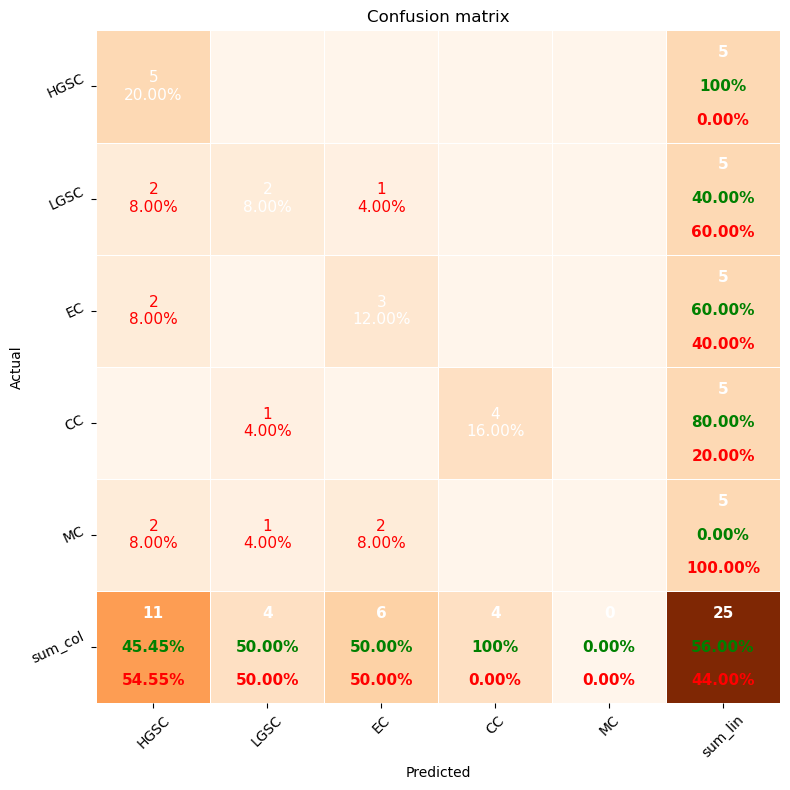

In [18]:
# Confusion matrix
import warnings
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
loss_fn = nn.CrossEntropyLoss(reduction='none')
datasets = get_tiles_datasets(CFG, train_image_dir, df_train, df_validation[df_validation.is_tma==True])
dataloaders = get_dataloaders(CFG, datasets)
y_list = []
pred_list = []
loss_list = []
metric = 0
with torch.no_grad():
    for X, y in dataloaders['validation']:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, y)
        y_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())
        loss_list.append(loss.cpu().numpy())
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=UserWarning)
            metric += balanced_accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
metric /= len(dataloaders['validation'])
y_list = np.concatenate(y_list)
pred_list = np.concatenate(pred_list)
loss_list = np.concatenate(loss_list)

from ext.pretty_confusion_matrix import pp_matrix
cm = confusion_matrix(y_list, pred_list)
df_cm = pd.DataFrame(cm, index=encode.keys(), columns=encode.keys())
pp_matrix(df_cm, pred_val_axis='x', cmap='Oranges', figsize=(8, 8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

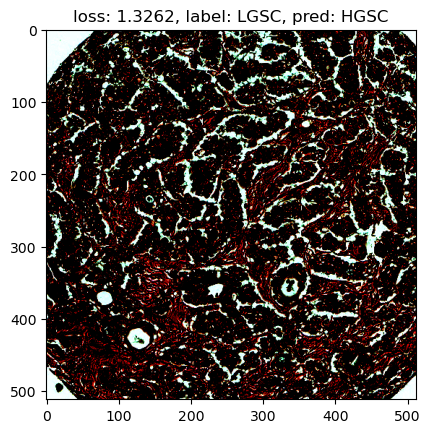

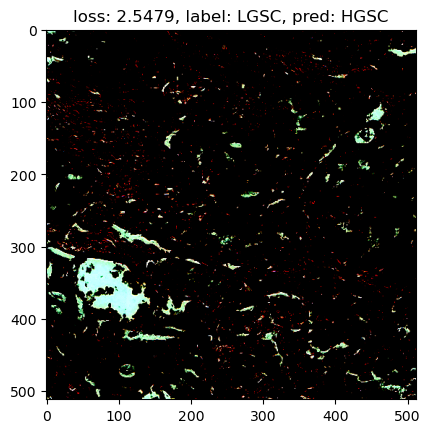

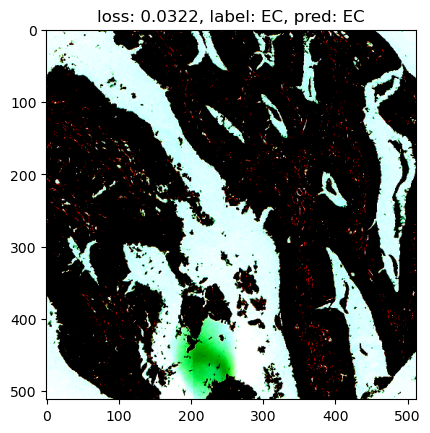

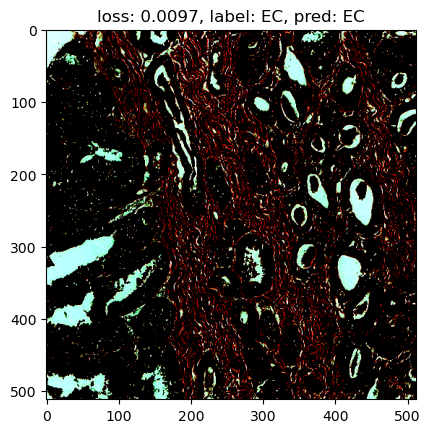

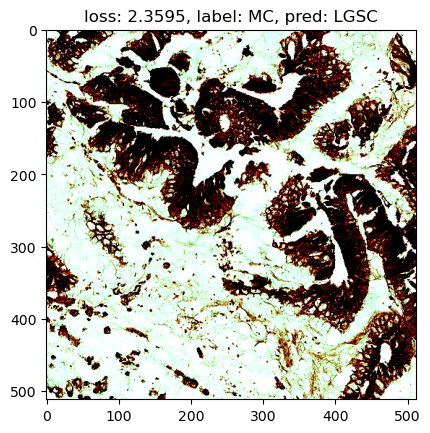

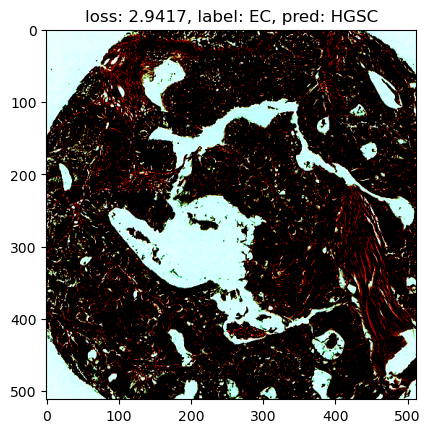

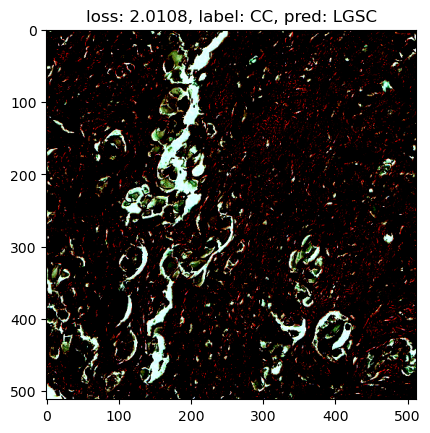

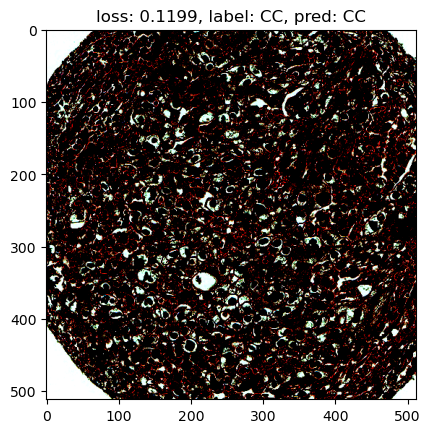

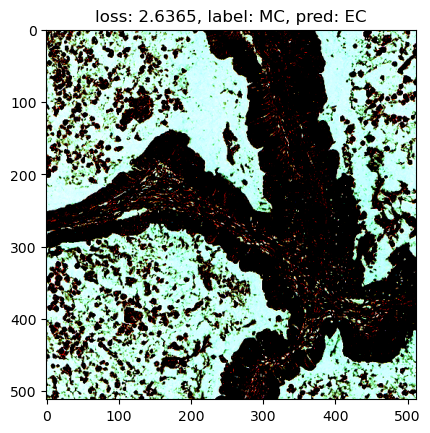

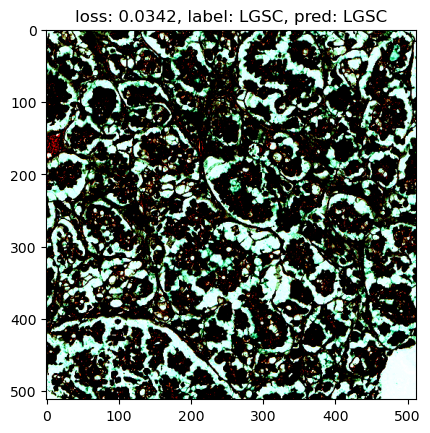

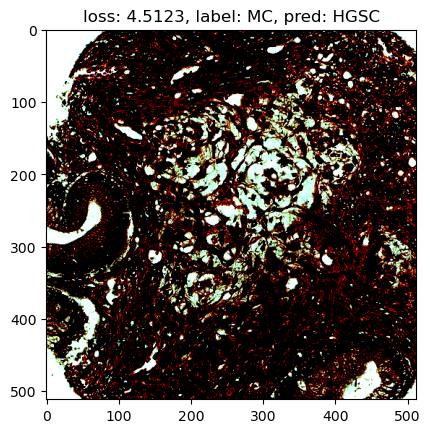

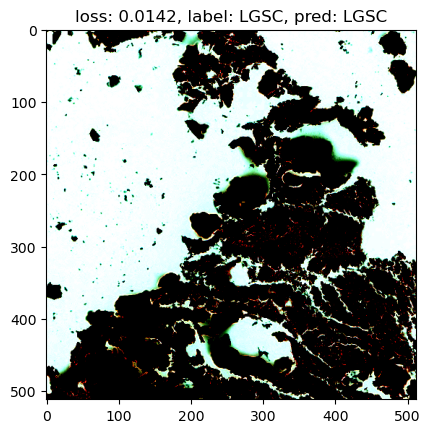

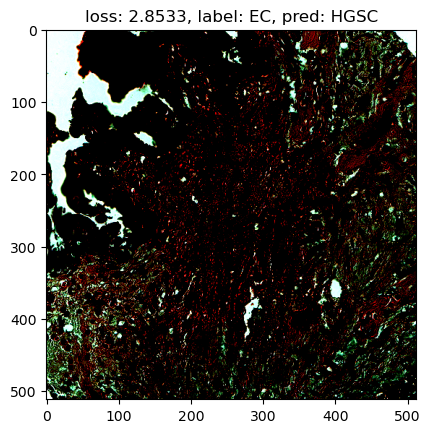

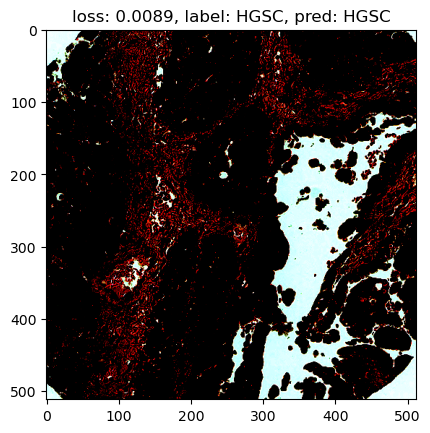

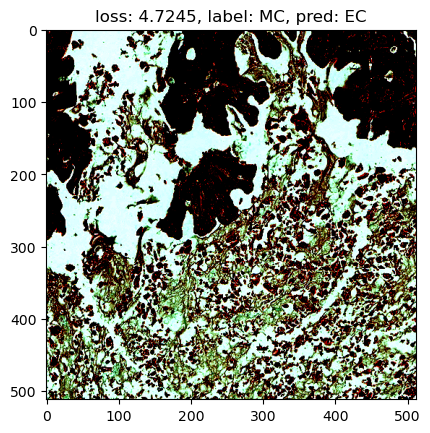

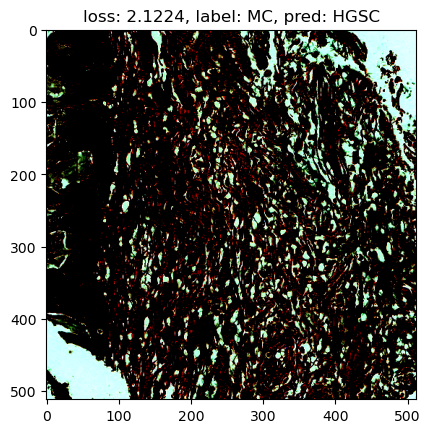

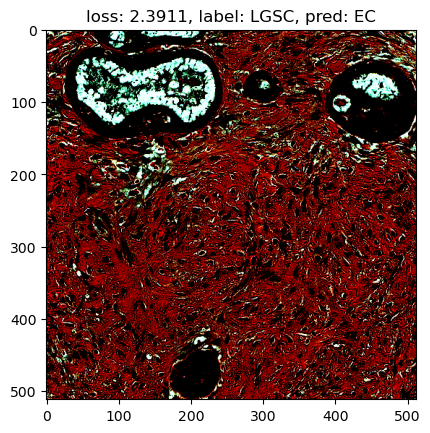

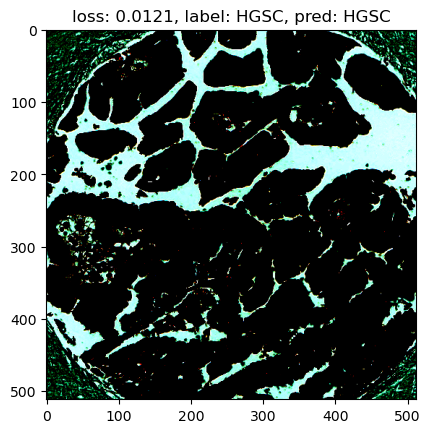

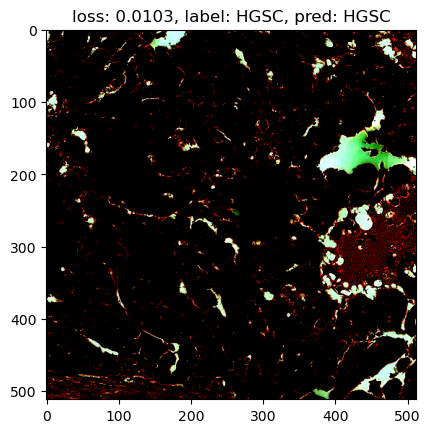

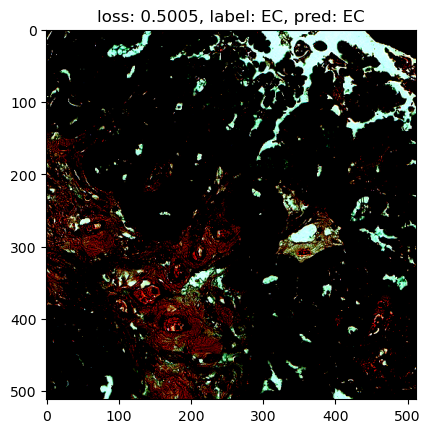

In [19]:
# Top k losses
k = 20
topk_loss_idx = list(loss_list.argsort()[-k:])
with torch.no_grad():
    for b, (X, y) in enumerate(dataloaders['validation']):
        for bi in range(len(X)):
            i = b * CFG['batch_size'] + bi
            if i not in topk_loss_idx:
                continue
            plt.figure()
            plt.imshow(X[bi].permute(1, 2, 0))
            plt.title(f'loss: {loss_list[i]:.4f}, label: {decode[y_list[i]]}, pred: {decode[pred_list[i]]}')